# Monet Painting GAN Project

In this project we will create a General Adversarial Network (GANs) that we will use to imitate the work of Claude Monet. To complete this task, we will create 2 neural networks; a generator and a discrimator model to create images and train to detect which look like Monet paintings and which do not. The general goal is for the generator model to create images that appear similar to Monet paintings and for the discriminator to properly identify this. 

To accomplish the above, we will go through the following stages:

1. Loading Images and Tensorflow Records data
2. Exploratory Data Analysis
3. Neural Network Modeling
4. Conclusion

### Citations
This code was based off a great notebook created by Amy Jang. It has been updated to allow for better finetuning and further analysis, but the basis of cycleGANs was adapted from this notebook.

Jang, A. (2020, August 29). Monet Cyclegan Tutorial. Kaggle. https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial 

## Modules

To start off we will load are modules. For this project we will be using tensorflow and its Keras backend for building and training the neural network. We will also use several basic data analysis models to aid us in loading data.

- glob - for loading files
- os - for parsing windows file strings
- cv2 - for loading images
- tqdm - for progess bars on loading image files
- matplotlib - graphing and visuals
- numpy - for math

In [1]:
import numpy as np
import os, cv2
from glob import glob
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, losses, optimizers, initializers
import tensorflow_addons as tfa

import time
import PIL

import gc

#### This is a useful code for identifying if tensorflow has accurately found your GPU and update memory growth.

In [2]:
### make sure tensorflow is using GPU
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print('Num GPUs Available: ' , len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1


## Loading Images
Let's start by loading the images so that we can perform some EDA. 

- load_images will load the number of images requested from a given list of files. This function utilizes cv2 to load the images and tqdm to provide a status bar to track how much progress is being made.

As the monet dataset consists of only 300 images, we will load them all. We will only load 2000 images from the photo dataset since that is more then enough to get a good idea of the distribution of the images.

In [3]:
def load_images(file_paths, n, image_size=(256, 256)):
    images = []
    for file in tqdm(file_paths[:n], desc="Loading images"):
        img = cv2.imread(file)
        if img is not None:
            img = cv2.resize(img, image_size)
            images.append(img)
    return np.array(images)

monet_image_paths = glob(r"C:\Users\Ryan\Files\DTSA 5511\Week 5\monet_jpg\*.jpg")
photo_image_paths = glob(r"C:\Users\Ryan\Files\DTSA 5511\Week 5\photo_jpg\*.jpg")


monet_images = load_images(monet_image_paths, 300)
photo_images = load_images(photo_image_paths, 2000)

Loading images:   0%|          | 0/300 [00:00<?, ?it/s]

Loading images:   0%|          | 0/2000 [00:00<?, ?it/s]

## Exploratory Data Analysis
Now that we have a function set to load the images, we can now proceed to perform a basic Exploratory Data Analysis to get some information about the pictures.

To start off, lets load 10 images from each dataset to get an idea of what the images look like. As the titles of the datasets suggest, the monet images are all paintings, while the photos are pictures or real places in the world. This will be important because the generator will need to learn how to create pictures like the monet dataset, while the discriminator will need to learn how to distinguish between pictures that look like monet or not.

In [4]:
def plot_sample_images(images, n=5):
    rows = (n // 5) + (1 if n % 5 != 0 else 0)
    cols = min(n, 5)
    
    fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))
    
    for i in range(n):
        row = i // 5
        col = i % 5
        axes[row, col].imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
        axes[row, col].axis('off')
    
    # If the total number of images is less than the total number of subplots, hide the remaining subplots
    for i in range(n, rows * cols):
        fig.delaxes(axes.flatten()[i])
    
    plt.show()

### Monet Images

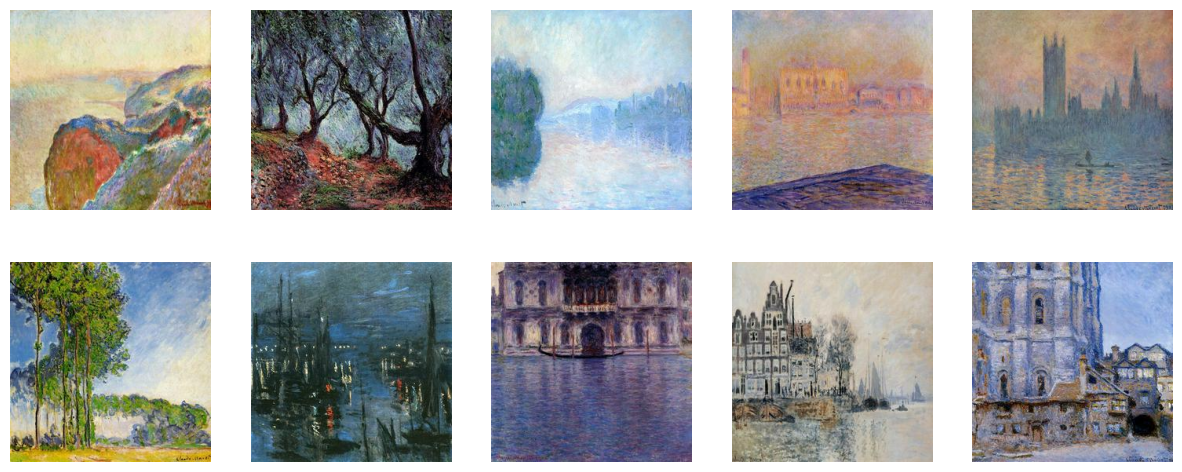

In [5]:
plot_sample_images(monet_images, 10)

### Photo Images

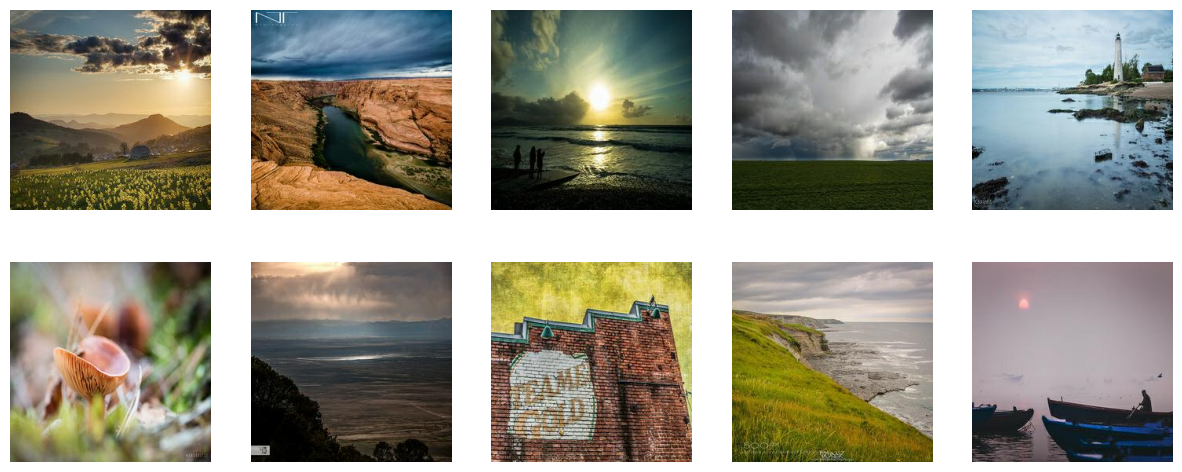

In [6]:
plot_sample_images(photo_images, 10)

### RGB Analysis
With the previous understanding of this lets check the distribution of colors and brightness in the pictures. For the 300 and 2000 samples we are looking at for this EDA we will check the RGB values and create Distribution charts for each of their colors and brightness.

#### Monet Images vs Photo Images

Interestingly, the distribution of colors for Monet and Photo datasets are quite different. 

- Red has a spike at 0 present in alot of monet images, but overall between 1 and 255 its a fairly normal distribution. However, in the photos, a large amount of pixels have no red color. 
- Green appears to be a normal distribution for the monet images, but has a high spike at 0 and appears to be skewed to the right.
- Blue appears to be a normal distribution for the monet images, but has a high spike at 0 and appears to be skewed to the right.
- Brightness and contrast both appear to be normally distributed across both images. 

In general Monet images seem to tend to have alittle bit of all colors in the paintings. On the otherhand photos appear to have more extremes. None of the images are purely black, but there are alot of really dark parts of images in the photos which appears to lead to this distribution. 

Monet Images:


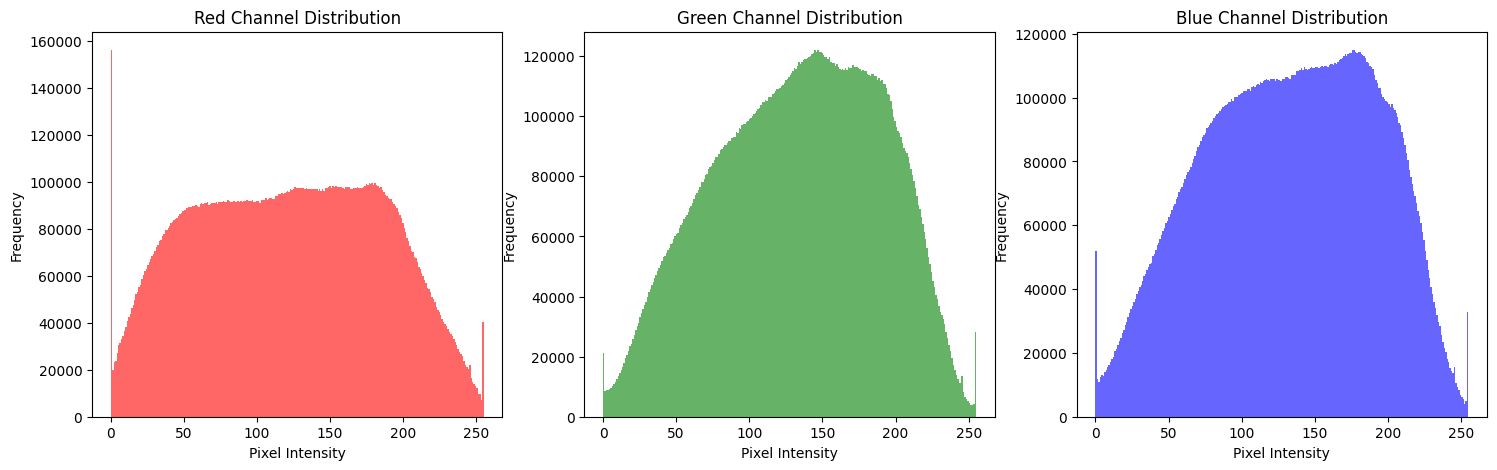

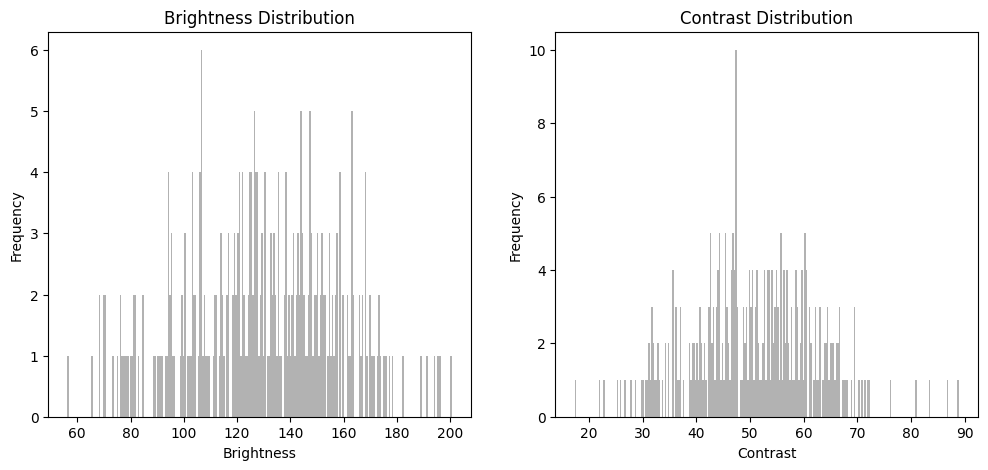

Monet Images - Mean: [121.57267919 133.72787954 132.96300456], Std: [62.98940003 56.17307173 57.86256085]
Monet Images - Average Brightness: 129.4211877610948, Average Contrast: 50.640604356017334
Photo Images:


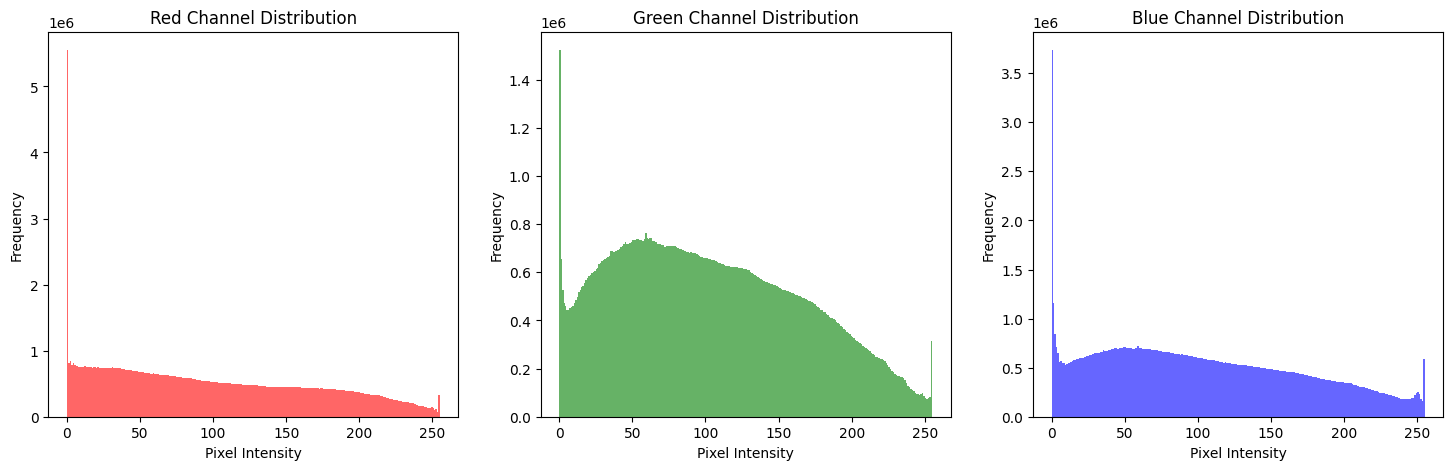

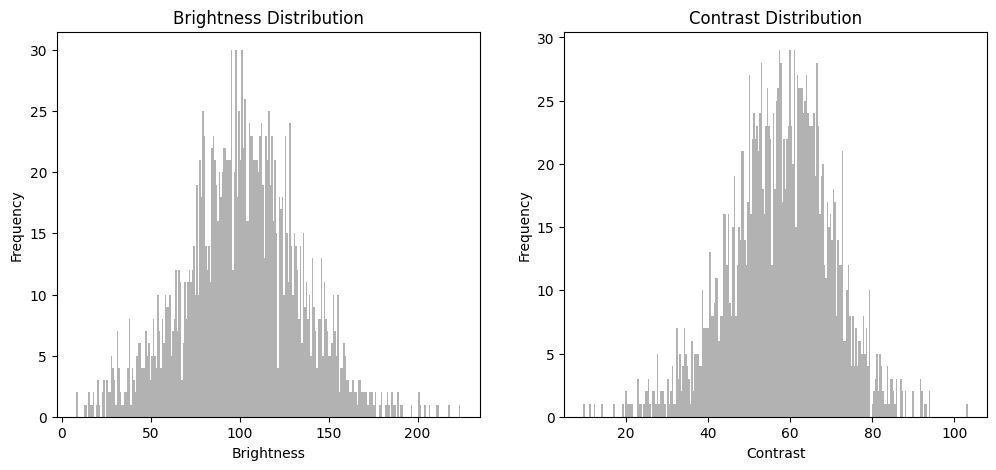

Photo Images - Mean: [ 97.76809275 103.88651012 102.88078619], Std: [70.11096735 63.34735136 68.53444175]
Photo Images - Average Brightness: 101.51179635365806, Average Contrast: 57.606430038983596


In [7]:
def compute_image_statistics(images):
    means = np.mean(images, axis=(0, 1, 2))
    stds = np.std(images, axis=(0, 1, 2))

    r_values = images[:, :, :, 0].flatten()
    g_values = images[:, :, :, 1].flatten()
    b_values = images[:, :, :, 2].flatten()

    plt.figure(figsize=(18, 5))
    plt.subplot(1, 3, 1)
    plt.hist(r_values, bins=256, color='red', alpha=0.6)
    plt.title('Red Channel Distribution')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')

    plt.subplot(1, 3, 2)
    plt.hist(g_values, bins=256, color='green', alpha=0.6)
    plt.title('Green Channel Distribution')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')

    plt.subplot(1, 3, 3)
    plt.hist(b_values, bins=256, color='blue', alpha=0.6)
    plt.title('Blue Channel Distribution')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')

    plt.show()

    brightness = np.mean(images, axis=(1, 2, 3))
    contrast = np.std(images, axis=(1, 2, 3))

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.hist(brightness, bins=256, color='gray', alpha=0.6)
    plt.title('Brightness Distribution')
    plt.xlabel('Brightness')
    plt.ylabel('Frequency')

    plt.subplot(1, 2, 2)
    plt.hist(contrast, bins=256, color='gray', alpha=0.6)
    plt.title('Contrast Distribution')
    plt.xlabel('Contrast')
    plt.ylabel('Frequency')

    plt.show()

    return means, stds, brightness.mean(), contrast.mean()

# Compute image statistics and plot distributions for monet
print("Monet Images:")
mean_0, std_0, avg_brightness_0, avg_contrast_0 = compute_image_statistics(monet_images)
print(f"Monet Images - Mean: {mean_0}, Std: {std_0}")
print(f"Monet Images - Average Brightness: {avg_brightness_0}, Average Contrast: {avg_contrast_0}")

# Compute image statistics and plot distributions for pictures
print("Photo Images:")
mean_1, std_1, avg_brightness_1, avg_contrast_1 = compute_image_statistics(photo_images)
print(f"Photo Images - Mean: {mean_1}, Std: {std_1}")
print(f"Photo Images - Average Brightness: {avg_brightness_1}, Average Contrast: {avg_contrast_1}")


#### Now lets clean up memory before loading the Tensorflow records dataset for modeling.

In [8]:
del monet_images, photo_images

##  Base Model

### Loading Tensorflow Record files 

The .tfrec file format allows us to more efficiently load the images as it loads the images in binary format that is optimized for tensorflow. This saves time and reduces computations of transforming the images into binary.

In [9]:
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [256, 256])
    image = (image / 127.5) - 1
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

def load_dataset(filenames):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

In [10]:
OUTPUT_CHANNELS = 3

monet_tfrec_paths = glob(r"C:\Users\Ryan\Files\DTSA 5511\Week 5\monet_tfrec\*.tfrec")
photo_tfrec_paths = glob(r"C:\Users\Ryan\Files\DTSA 5511\Week 5\photo_tfrec\*.tfrec")

monet_dataset = load_dataset(monet_tfrec_paths).batch(1)
photo_dataset = load_dataset(photo_tfrec_paths).batch(1)

### Downsample
This function reduces the width and height of the image according to the stride. In this case we will use a default of 2, but we will set is as a variable if we want to change it for tuning later. We are also enabling batch normalization  and instance normalization so that we can compare them. The function is setup so that only 1 of the normalization techniques can be used at a time.

In [11]:
def downsample(filters, size, apply_instancenorm = True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))
    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))   
        
    result.add(layers.LeakyReLU())
    return result

### Upsample
Upsampling does the opposite of downsample, and increases the dimension of the images by the stride. Like before we are using batchnorm and instancenoralization in the function for future testing and allowing stride to be passed as a variable. 

In [12]:
def upsample(filters, size, apply_instancenorm = True, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = initializers.RandomNormal(mean=0.0, stddev=0.02)
    
    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2, padding='same', 
                                      kernel_initializer=initializer, use_bias=False))
    
    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))
    if apply_dropout:
        result.add(layers.Dropout(0.5))
        
    result.add(layers.ReLU())
    return result

### Generator

In this stage we will build our generator. We will start by downsampling the image. This results in a significant amount of information being lost due to the reduction in spatial resolution. While downsampling through the downsample stack, this information is stored in the Skip Connections list. We then reverse the list except for the 1st element and begin upsampling. The upsampling then combines the hihg level information of the upsampling layer with the low level features in the skip list from the downsampling path. This results in higher quality images and helps us bypass the vanishing gradient problem.

In [13]:
def Generator():
        
    inputs = layers.Input(shape=[256, 256, 3])

    down_stack = [
        downsample(64, 4, apply_instancenorm=False),
        downsample(128, 4, apply_instancenorm=True),
        downsample(256, 4, apply_instancenorm=True),
        downsample(512, 4, apply_instancenorm=True),
        downsample(512, 4, apply_instancenorm=True),
        downsample(512, 4, apply_instancenorm=True),
        downsample(512, 4, apply_instancenorm=True),
        downsample(512, 4, apply_instancenorm=True)
    ]

    up_stack = [
        upsample(512, 4, apply_instancenorm=True, apply_dropout=True),
        upsample(512, 4, apply_instancenorm=True, apply_dropout=True),
        upsample(512, 4, apply_instancenorm=True, apply_dropout=True),
        upsample(512, 4, apply_instancenorm=True),
        upsample(256, 4, apply_instancenorm=True),
        upsample(128, 4, apply_instancenorm=True),
        upsample(64, 4, apply_instancenorm=True)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4, strides=2, padding='same', 
                                  kernel_initializer=initializer, activation='tanh')
    x = inputs
    
    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])
    
    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

### Discriminator
The Discriminator then acts as a classifier model that takes in the images and classifies them as real or fake. However, instead of outputing a single node like in a standard binary classification problem, it outputs a smaller image with pixel values that indicate a real or fake classifier based off the value. Real images will have a high pixel value while fake images will have a low pixel value.

In [14]:
def Discriminator():
        
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = initializers.RandomNormal(mean=0.0, stddev=0.02)
    
    inputs = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inputs

    down1 = downsample(64, 4, apply_instancenorm=False)(x)
    down2 = downsample(128, 4, apply_instancenorm=True)(down1) 
    down3 = downsample(256, 4, apply_instancenorm=True)(down2) 

    zero_pad1 = layers.ZeroPadding2D()(down3) 
    conv = layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer, use_bias=False)(zero_pad1)

    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)
        
    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu)
    last = layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2)

    return keras.Model(inputs=inputs, outputs=last)

### CycleGAN

Below we will setup a class for our CycleGAN. First, we will start out by identifying our loss functions for the discriminator, generator, L1, and identity Loss.

We will then build our class for the cycle gan which utilizes our Generator and discriminator models, as well as the loss functions to change photos into Monet like images, and Discriminate if the image was a photo or a Monet painting. This class was built using `keras.Model` which allows us to utilize the fit function as opposed to having to write the function ourselves. 

In [15]:
loss_obj = losses.BinaryCrossentropy(from_logits=True, reduction=losses.Reduction.NONE)

def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss
    return tf.reduce_mean(total_disc_loss * 0.5)

def generator_loss(generated):
    return tf.reduce_mean(loss_obj(tf.ones_like(generated), generated))

# Cycle consistency loss (L1 loss)
def calc_cycle_loss(real_image, cycled_image, lambda_cycle):
    loss = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return lambda_cycle * loss

# Identity loss
def identity_loss(real_image, same_image, lambda_cycle):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return lambda_cycle * 0.5 * loss

In [16]:
class CycleGan(keras.Model):
    def __init__(self, monet_generator, photo_generator, monet_discriminator, photo_discriminator, lambda_cycle=10):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle

    def compile(self, m_gen_optimizer, p_gen_optimizer, m_disc_optimizer, p_disc_optimizer, gen_loss_fn, disc_loss_fn, cycle_loss_fn, identity_loss_fn):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn

    def train_step(self, batch_data):
        real_monet, real_photo = batch_data

        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)
            
            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss, self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss, self.p_gen.trainable_variables)       
        monet_discriminator_gradients = tape.gradient(monet_disc_loss, self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss, self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients, self.m_gen.trainable_variables))
        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients, self.p_gen.trainable_variables))
        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients, self.m_disc.trainable_variables))
        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients, self.p_disc.trainable_variables))

        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

### Running the Model

In this step we will run the above model. To start off, we will initialize the Generator and Discriminator and initialize our code to use Adam as the optimizer with a learning rate of `2e-4` and a `beta_1=0.5`. We will then initialize our CycleGan and run the compile function within the GAN. Finally we can use the keras fit function with 20 epochs to get our final model.

In [17]:
# Instantiate the generators and discriminators
monet_generator = Generator()
photo_generator = Generator()
monet_discriminator = Discriminator()
photo_discriminator = Discriminator()

# Define the optimizers
monet_generator_optimizer = optimizers.Adam(2e-4, beta_1=0.5)
photo_generator_optimizer = optimizers.Adam(2e-4, beta_1=0.5)
monet_discriminator_optimizer = optimizers.Adam(2e-4, beta_1=0.5)
photo_discriminator_optimizer = optimizers.Adam(2e-4, beta_1=0.5)

# Build the CycleGAN model
cycle_gan_model = CycleGan(monet_generator, photo_generator, monet_discriminator, photo_discriminator)

cycle_gan_model.compile(
    m_gen_optimizer=monet_generator_optimizer,
    p_gen_optimizer=photo_generator_optimizer,
    m_disc_optimizer=monet_discriminator_optimizer,
    p_disc_optimizer=photo_discriminator_optimizer,
    gen_loss_fn=generator_loss,
    disc_loss_fn=discriminator_loss,
    cycle_loss_fn=calc_cycle_loss,
    identity_loss_fn=identity_loss
)

# Training the CycleGAN model
cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_dataset, photo_dataset)), epochs=30)

Epoch 1/30
300/300 [==============================] - 112s 285ms/step - monet_gen_loss: 5.2176 - photo_gen_loss: 5.4437 - monet_disc_loss: 0.6558 - photo_disc_loss: 0.6109
Epoch 2/30
300/300 [==============================] - 85s 284ms/step - monet_gen_loss: 3.6266 - photo_gen_loss: 3.7477 - monet_disc_loss: 0.6641 - photo_disc_loss: 0.6185
Epoch 3/30
300/300 [==============================] - 85s 284ms/step - monet_gen_loss: 3.5668 - photo_gen_loss: 3.7031 - monet_disc_loss: 0.6542 - photo_disc_loss: 0.6187
Epoch 4/30
300/300 [==============================] - 85s 284ms/step - monet_gen_loss: 3.4472 - photo_gen_loss: 3.5807 - monet_disc_loss: 0.6417 - photo_disc_loss: 0.6096
Epoch 5/30
300/300 [==============================] - 85s 283ms/step - monet_gen_loss: 3.3645 - photo_gen_loss: 3.5073 - monet_disc_loss: 0.6278 - photo_disc_loss: 0.5940
Epoch 6/30
300/300 [==============================] - 85s 284ms/step - monet_gen_loss: 3.3044 - photo_gen_loss: 3.4797 - monet_disc_loss: 0.6229

### Visualizing the Model
Next we will check some of the images to see how well the model performed at Generating the images in Monet style. The below function prints a number of photos so we can compare. The images are starting to look more Monet-like, but there is still room for improvement. 

In [18]:
def visualize_predictions(photo_dataset, monet_generator, num_images=5):
    _, ax = plt.subplots(num_images, 2, figsize=(12, 12))
    for i, img in enumerate(photo_dataset.take(num_images)):
        prediction = monet_generator(img, training=False)[0].numpy()
        prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
        img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

        ax[i, 0].imshow(img)
        ax[i, 1].imshow(prediction)
        ax[i, 0].set_title("Input Photo")
        ax[i, 1].set_title("Monet-esque")
        ax[i, 0].axis("off")
        ax[i, 1].axis("off")
    plt.show()

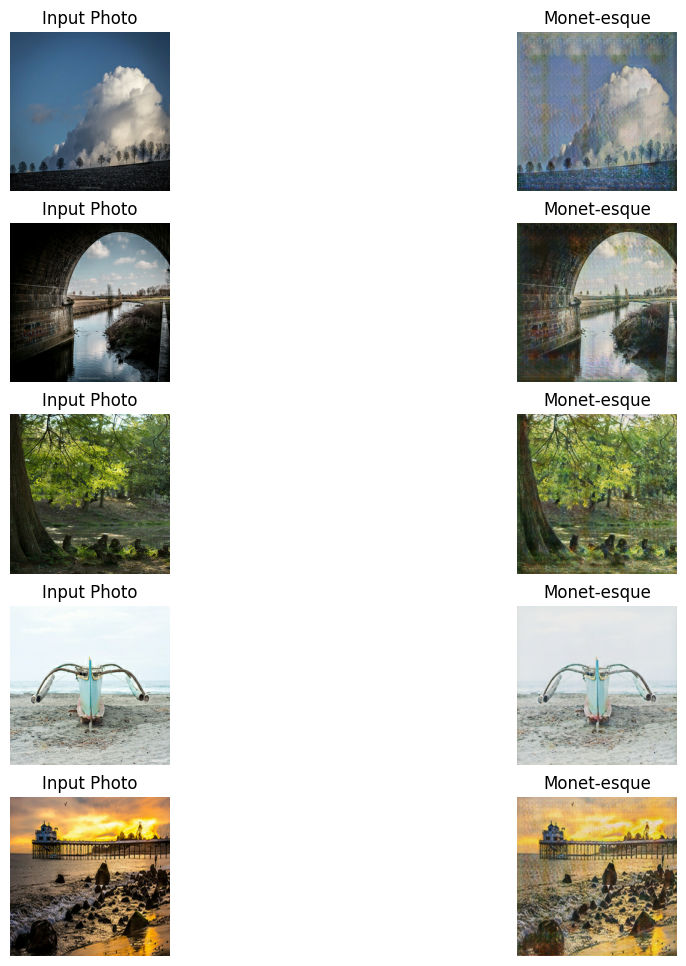

In [19]:
visualize_predictions(photo_dataset, monet_generator)

### Outputing files

This is for outputing the files to see how they perform against the Kaggle Dataset. For now it's outputting locally, but later it will publish directly to Kaggle. This is performing at a public score of 54 currently, which is decent but there is still alot of room for improvement.

In [20]:
dir_num = 1

def save_predictions(photo_dataset, monet_generator):
    global dir_num
    output_dir = rf"C:\Users\Ryan\Files\DTSA 5511\Week 5\results_{dir_num}"
    os.makedirs(output_dir, exist_ok=True)
    
    for i, img in enumerate(photo_dataset):
        prediction = monet_generator(img, training=False)[0].numpy()
        prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
        img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

        img_pil = PIL.Image.fromarray(prediction)
        img_pil.save(os.path.join(output_dir, f"monet_style_{i+1}.jpg"))
    
    dir_num += 1
    print(f"Predictions saved to {output_dir}")

In [21]:
save_predictions(photo_dataset, monet_generator)

Predictions saved to C:\Users\Ryan\Files\DTSA 5511\Week 5\results_1


In [22]:
del monet_generator, photo_generator, monet_discriminator, photo_discriminator, cycle_gan_model
gc.collect()

22353

## Improving the model

After performing further research on GANs, I saw that the model can be improved significantly by implementing a multiple discriminator model where you evaluate the images from different perspectives using 2 discriminator model using both Binary Crossentropy like before and adding a 2nd discriminator using hinge loss. 1 of the discriminator models gives a higher score to fake images while using Binary Crossentropy and the other model gives a higher score to real images using hinge loss. This is then passed back to the Generators to better improve the model.


The below adjustments were adjusted from another project and from a paper on this updated GAN network. 
Two-objective discriminator Kaggle. https://www.kaggle.com/code/unfriendlyai/two-objective-discriminator 


### Data Loading
After further research, it appears that combining the 2 datasets could help us better generalize the model and make it perform better. We will combine these datasets into a single dataset to feed into the model to improve its training. We will also transition from a batch size of 1 to a batch size of 8 to improve performance and training.

In [13]:
def get_gan_dataset(monet_files, photo_files, augment=None, repeat=True, shuffle=True, batch_size=1):
    monet_ds = load_dataset(monet_files)
    photo_ds = load_dataset(photo_files)
    
    if augment:
        monet_ds = monet_ds.map(augment, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        photo_ds = photo_ds.map(augment, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    if repeat:
        monet_ds = monet_ds.repeat()
        photo_ds = photo_ds.repeat()
        
    if shuffle:
        monet_ds = monet_ds.shuffle(1024)
        photo_ds = photo_ds.shuffle(1024)
        
    monet_ds = monet_ds.batch(batch_size, drop_remainder=True)
    photo_ds = photo_ds.batch(batch_size, drop_remainder=True)
    
    gan_ds = tf.data.Dataset.zip((monet_ds, photo_ds))
    
    return gan_ds


In [14]:
BATCH_SIZE=8
final_dataset = get_gan_dataset(monet_tfrec_paths, photo_tfrec_paths, augment=None, repeat=True, shuffle=True, batch_size=BATCH_SIZE)

### Adding in Data Augmentation

Now we will add in data augmentation to improve the training and generalization of the model.

1. brightness
2. saturation
3. contrast
4. translation
    - this will randomly shift the image by upto 32 pixels to make images look different
6. cutout
    - this will set small parts of images to blank, so the model generalizes better as random parts of the images will be provided with changes over multiple epochs.

Zhao, S. (n.d.). Data-efficient-gans. GitHub. https://github.com/mit-han-lab/data-efficient-gans/blob/master/DiffAugment_tf.py 

In [19]:
def DiffAugment(x, policy='', channels_first=False):
        if policy:
            if channels_first:
                x = tf.transpose(x, [0, 2, 3, 1])
            for p in policy.split(','):
                for f in AUGMENT_FNS[p]:
                    x = f(x)
            if channels_first:
                x = tf.transpose(x, [0, 3, 1, 2])
        return x

def rand_brightness(x):
    magnitude = tf.random.uniform([tf.shape(x)[0], 1, 1, 1]) - 0.5
    x = x + magnitude
    return x

def rand_saturation(x):
    magnitude = tf.random.uniform([tf.shape(x)[0], 1, 1, 1]) * 2
    x_mean = tf.reduce_sum(x, axis=3, keepdims=True) * 0.3333333333333333333
    x = (x - x_mean) * magnitude + x_mean
    return x

def rand_contrast(x):
    magnitude = tf.random.uniform([tf.shape(x)[0], 1, 1, 1]) + 0.5
    x_mean = tf.reduce_sum(x, axis=[1, 2, 3], keepdims=True) * 5.086e-6
    x = (x - x_mean) * magnitude + x_mean
    return x

def rand_translation(x, ratio=0.125):
    batch_size = tf.shape(x)[0]
    image_size = tf.shape(x)[1:3]
    shift = tf.cast(tf.cast(image_size, tf.float32) * ratio + 0.5, tf.int32)
    translation_x = tf.random.uniform([batch_size, 1], -shift[0], shift[0] + 1, dtype=tf.int32)
    translation_y = tf.random.uniform([batch_size, 1], -shift[1], shift[1] + 1, dtype=tf.int32)
    grid_x = tf.clip_by_value(tf.expand_dims(tf.range(image_size[0], dtype=tf.int32), 0) + translation_x + 1, 0, image_size[0] + 1)
    grid_y = tf.clip_by_value(tf.expand_dims(tf.range(image_size[1], dtype=tf.int32), 0) + translation_y + 1, 0, image_size[1] + 1)
    x = tf.gather_nd(tf.pad(x, [[0, 0], [1, 1], [0, 0], [0, 0]]), tf.expand_dims(grid_x, -1), batch_dims=1)
    x = tf.transpose(tf.gather_nd(tf.pad(tf.transpose(x, [0, 2, 1, 3]), [[0, 0], [1, 1], [0, 0], [0, 0]]), tf.expand_dims(grid_y, -1), batch_dims=1), [0, 2, 1, 3])
    return x

def rand_cutout(x, ratio=0.5):
    batch_size = tf.shape(x)[0]
    image_size = tf.shape(x)[1:3]
    cutout_size = tf.cast(tf.cast(image_size, tf.float32) * ratio + 0.5, tf.int32)
    offset_x = tf.random.uniform([tf.shape(x)[0], 1, 1], maxval=image_size[0] + (1 - cutout_size[0] % 2), dtype=tf.int32)
    offset_y = tf.random.uniform([tf.shape(x)[0], 1, 1], maxval=image_size[1] + (1 - cutout_size[1] % 2), dtype=tf.int32)
    grid_batch, grid_x, grid_y = tf.meshgrid(tf.range(batch_size, dtype=tf.int32), tf.range(cutout_size[0], dtype=tf.int32), tf.range(cutout_size[1], dtype=tf.int32), indexing='ij')
    cutout_grid = tf.stack([grid_batch, grid_x + offset_x - cutout_size[0] // 2, grid_y + offset_y - cutout_size[1] // 2], axis=-1)
    mask_shape = tf.stack([batch_size, image_size[0], image_size[1]])
    cutout_grid = tf.maximum(cutout_grid, 0)
    cutout_grid = tf.minimum(cutout_grid, tf.reshape(mask_shape - 1, [1, 1, 1, 3]))
    mask = tf.maximum(1 - tf.scatter_nd(cutout_grid, tf.ones([batch_size, cutout_size[0], cutout_size[1]], dtype=tf.float32), mask_shape), 0)
    x = x * tf.expand_dims(mask, axis=3)
    return x

AUGMENT_FNS = {
    'color': [rand_brightness, rand_saturation, rand_contrast],
    'translation': [rand_translation],
    'cutout': [rand_cutout],
}
def aug_fn(image):
    return DiffAugment(image,"color,translation,cutout")

### Discriminator Models
Now let's update our discriminator model. We are going from a single Generator Discriminator model to a model that utilizes 2 Discrimators to categorize the images. 

1. Headless Discriminator - Processes both Monet and photos and outputs a feature map of shape [33.33,512] which then works with the Head function below.
2. Photo Discriminator - This is a 2nd discriminator design to classify photo images and produce a single output of shape [30,30,1].
3. Head for 2-objective discrimator - works with the Discriminator model to process both hinge loss and binary crossentropy.

We will then create 2 new loss functions which are designed to handle the hinge loss for the 2 objective discriminator.

In [15]:
def Discriminator():
        
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = initializers.RandomNormal(mean=0.0, stddev=0.02)
    
    inputs = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inputs

    down1 = downsample(64, 4, apply_instancenorm=False)(x)
    down2 = downsample(128, 4, apply_instancenorm=True)(down1) 
    down3 = downsample(256, 4, apply_instancenorm=True)(down2) 

    zero_pad1 = layers.ZeroPadding2D()(down3) 
    conv = layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer, use_bias=False)(zero_pad1)

    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)    
    leaky_relu = layers.LeakyReLU()(norm1)
    zero_pad2 = layers.ZeroPadding2D()(leaky_relu)
    return keras.Model(inputs=inputs, outputs=zero_pad2)
    
def DiscriminatorP():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
    
    inputs = layers.Input(shape=[256, 256, 3], name='input_image')
    x = inputs
    
    down1 = downsample(64, 4, False)(x)       
    down2 = downsample(128, 4)(down1)        
    down3 = downsample(256, 4)(down2)  

    zero_pad1 = layers.ZeroPadding2D()(down3)
    conv = layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer, use_bias=False)(zero_pad1)

    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)
    leaky_relu = layers.LeakyReLU()(norm1)
    zero_pad2 = layers.ZeroPadding2D()(leaky_relu)
    last = layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2)
    
    return keras.Model(inputs=inputs, outputs=last)

def DHead():
    initializer = tf.random_normal_initializer(0., 0.02)
    
    inputs = layers.Input(shape=[33, 33, 512], name='input_image')
    x = inputs
    
    last = layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(x) # (size, 30, 30, 1)

    return keras.Model(inputs=inputs, outputs=last)

In [16]:
def discriminator_loss1(real, generated):
    real_loss = tf.math.minimum(tf.zeros_like(real), real - tf.ones_like(real))
    generated_loss = tf.math.minimum(tf.zeros_like(generated), -generated - tf.ones_like(generated))
    total_disc_loss = real_loss + generated_loss
    return tf.reduce_mean(-total_disc_loss * 0.5)

def generator_loss1(generated):
    return tf.reduce_mean(-generated)

### Updated Model

We will update our model to work with the above updated 2 objective model. 

In [17]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        dhead1,
        dhead2,
        lambda_cycle=3,
        lambda_id=3
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        self.lambda_id = lambda_id
        self.dhead1 = dhead1
        self.dhead2 = dhead2
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        gen_loss_fn1,
        disc_loss_fn,
        disc_loss_fn1,
        cycle_loss_fn,
        identity_loss_fn,
        aug_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.gen_loss_fn1 = gen_loss_fn1
        self.disc_loss_fn = disc_loss_fn
        self.disc_loss_fn1 = disc_loss_fn1
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        self.aug_fn = aug_fn
        self.step_num = 0
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        batch_size = tf.shape(real_monet)[0]
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)
            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)
            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # Diffaugment
            both_monet = tf.concat([real_monet, fake_monet], axis=0)
            aug_monet = self.aug_fn(both_monet)
            aug_real_monet = aug_monet[:batch_size]
            aug_fake_monet = aug_monet[batch_size:]

            # two-objective discriminator
            disc_fake_monet1 = self.dhead1(self.m_disc(aug_fake_monet, training=True), training=True)
            disc_real_monet1 = self.dhead1(self.m_disc(aug_real_monet, training=True), training=True)
            disc_fake_monet2 = self.dhead2(self.m_disc(aug_fake_monet, training=True), training=True)
            disc_real_monet2 = self.dhead2(self.m_disc(aug_real_monet, training=True), training=True)

            monet_gen_loss1 = self.gen_loss_fn1(disc_fake_monet1)
            monet_head_loss1 = self.disc_loss_fn1(disc_real_monet1, disc_fake_monet1)
            monet_gen_loss2 = self.gen_loss_fn(disc_fake_monet2)
            monet_head_loss2 = self.disc_loss_fn(disc_real_monet2, disc_fake_monet2)

            monet_gen_loss = (monet_gen_loss1 + monet_gen_loss2) * 0.4
            monet_disc_loss = monet_head_loss1 + monet_head_loss2

            # discriminator used to check, inputting real images
            disc_real_photo = self.p_disc(real_photo, training=True)
            # discriminator used to check, inputting fake images
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates discriminator loss
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

            # evaluates total generator loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle / tf.cast(batch_size, tf.float32)) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle / tf.cast(batch_size, tf.float32))
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_id / tf.cast(batch_size, tf.float32))
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_id / tf.cast(batch_size, tf.float32))

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss, self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss, self.p_gen.trainable_variables)
        monet_discriminator_gradients = tape.gradient(monet_disc_loss, self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss, self.p_disc.trainable_variables)

        # Heads gradients
        monet_head_gradients1 = tape.gradient(monet_head_loss1, self.dhead1.trainable_variables)
        self.m_disc_optimizer.apply_gradients(zip(monet_head_gradients1, self.dhead1.trainable_variables))
        monet_head_gradients2 = tape.gradient(monet_head_loss2, self.dhead2.trainable_variables)
        self.m_disc_optimizer.apply_gradients(zip(monet_head_gradients2, self.dhead2.trainable_variables))

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients, self.m_gen.trainable_variables))
        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients, self.p_gen.trainable_variables))
        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients, self.m_disc.trainable_variables))
        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients, self.p_disc.trainable_variables))
        
        return {
            "monet_head_loss1": monet_head_loss1,
            "monet_head_loss2": monet_head_loss2,
            "disc_real_monet": disc_real_monet1,
            "disc_fake_monet": disc_fake_monet1,
            "disc_real_monet2": disc_real_monet2,
            "disc_fake_monet2": disc_fake_monet2,
            "monet_gen_loss": monet_gen_loss,
            "photo_disc_loss": photo_disc_loss,
        }

In [21]:
monet_generator = Generator()
photo_generator = Generator()
monet_discriminator = Discriminator()
photo_discriminator = DiscriminatorP()
dHead1 = DHead()
dHead2 = DHead()

# Define the optimizer
monet_generator_optimizer = optimizers.Adam(8e-4, beta_1=0.5)
photo_generator_optimizer = optimizers.Adam(8e-4, beta_1=0.5)
monet_discriminator_optimizer = optimizers.Adam(8e-4, beta_1=0.5)
photo_discriminator_optimizer = optimizers.Adam(8e-4, beta_1=0.5)

cycle_gan_model = CycleGan(
    monet_generator, photo_generator, monet_discriminator, photo_discriminator, dHead1, dHead2
)

cycle_gan_model.compile(
    m_gen_optimizer=monet_generator_optimizer,
    p_gen_optimizer=photo_generator_optimizer,
    m_disc_optimizer=monet_discriminator_optimizer,
    p_disc_optimizer=photo_discriminator_optimizer,
    gen_loss_fn=generator_loss,
    gen_loss_fn1=generator_loss1,
    disc_loss_fn=discriminator_loss,
    disc_loss_fn1=discriminator_loss1,
    cycle_loss_fn=calc_cycle_loss,
    identity_loss_fn=identity_loss,
    aug_fn=aug_fn,
)

cycle_gan_model.fit(final_dataset, steps_per_epoch=918, epochs=15)

Epoch 1/15
918/918 [==============================] - 510s 536ms/step - monet_head_loss1: 0.9955 - monet_head_loss2: 0.6930 - disc_real_monet: -0.0416 - disc_fake_monet: -0.0522 - disc_real_monet2: 0.0023 - disc_fake_monet2: -0.0011 - monet_gen_loss: 0.2986 - photo_disc_loss: 0.6873
Epoch 2/15
918/918 [==============================] - 492s 536ms/step - monet_head_loss1: 0.9964 - monet_head_loss2: 0.6933 - disc_real_monet: -0.0093 - disc_fake_monet: -0.0180 - disc_real_monet2: 5.1116e-04 - disc_fake_monet2: -6.2989e-04 - monet_gen_loss: 0.2848 - photo_disc_loss: 0.6906
Epoch 3/15
918/918 [==============================] - 492s 536ms/step - monet_head_loss1: 0.9997 - monet_head_loss2: 0.6933 - disc_real_monet: 0.0056 - disc_fake_monet: 0.0047 - disc_real_monet2: -2.3102e-04 - disc_fake_monet2: 2.0259e-05 - monet_gen_loss: 0.2754 - photo_disc_loss: 0.6884
Epoch 4/15
918/918 [==============================] - 493s 537ms/step - monet_head_loss1: 0.9615 - monet_head_loss2: 0.6846 - disc_rea

In [22]:
monet_generator_optimizer = optimizers.Adam(2e-4, beta_1=0.5)
photo_generator_optimizer = optimizers.Adam(2e-4, beta_1=0.5)
monet_discriminator_optimizer = optimizers.Adam(2e-4, beta_1=0.5)
photo_discriminator_optimizer = optimizers.Adam(2e-4, beta_1=0.5)

cycle_gan_model.compile(
    m_gen_optimizer=monet_generator_optimizer,
    p_gen_optimizer=photo_generator_optimizer,
    m_disc_optimizer=monet_discriminator_optimizer,
    p_disc_optimizer=photo_discriminator_optimizer,
    gen_loss_fn=generator_loss,
    gen_loss_fn1=generator_loss1,
    disc_loss_fn=discriminator_loss,
    disc_loss_fn1=discriminator_loss1,
    cycle_loss_fn=calc_cycle_loss,
    identity_loss_fn=identity_loss,
    aug_fn=aug_fn,
)

cycle_gan_model.fit(final_dataset, steps_per_epoch=918, epochs=10)

Epoch 1/10
918/918 [==============================] - 511s 536ms/step - monet_head_loss1: 0.8291 - monet_head_loss2: 0.6465 - disc_real_monet: 0.2656 - disc_fake_monet: -0.2020 - disc_real_monet2: 0.2324 - disc_fake_monet2: -0.2465 - monet_gen_loss: 0.4390 - photo_disc_loss: 0.6435
Epoch 2/10
918/918 [==============================] - 495s 539ms/step - monet_head_loss1: 0.8034 - monet_head_loss2: 0.6320 - disc_real_monet: 0.3287 - disc_fake_monet: -0.2187 - disc_real_monet2: 0.2517 - disc_fake_monet2: -0.2763 - monet_gen_loss: 0.4528 - photo_disc_loss: 0.6560
Epoch 3/10
918/918 [==============================] - 494s 539ms/step - monet_head_loss1: 0.7792 - monet_head_loss2: 0.6208 - disc_real_monet: 0.3753 - disc_fake_monet: -0.2727 - disc_real_monet2: 0.2892 - disc_fake_monet2: -0.3236 - monet_gen_loss: 0.4890 - photo_disc_loss: 0.6690
Epoch 4/10
918/918 [==============================] - 494s 538ms/step - monet_head_loss1: 0.7845 - monet_head_loss2: 0.6225 - disc_real_monet: 0.3732 -

ResourceExhaustedError: Graph execution error:

Detected at node 'gradient_tape/model_7/conv2d_transpose_31/conv2d_transpose/Conv2D' defined at (most recent call last):
    File "C:\Users\Ryan\anaconda3\envs\tf-gpu\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\Ryan\anaconda3\envs\tf-gpu\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\Ryan\anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\Ryan\anaconda3\envs\tf-gpu\lib\site-packages\traitlets\config\application.py", line 992, in launch_instance
      app.start()
    File "C:\Users\Ryan\anaconda3\envs\tf-gpu\lib\site-packages\ipykernel\kernelapp.py", line 701, in start
      self.io_loop.start()
    File "C:\Users\Ryan\anaconda3\envs\tf-gpu\lib\site-packages\tornado\platform\asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\Ryan\anaconda3\envs\tf-gpu\lib\asyncio\windows_events.py", line 321, in run_forever
      super().run_forever()
    File "C:\Users\Ryan\anaconda3\envs\tf-gpu\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "C:\Users\Ryan\anaconda3\envs\tf-gpu\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "C:\Users\Ryan\anaconda3\envs\tf-gpu\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\Ryan\anaconda3\envs\tf-gpu\lib\site-packages\ipykernel\kernelbase.py", line 534, in dispatch_queue
      await self.process_one()
    File "C:\Users\Ryan\anaconda3\envs\tf-gpu\lib\site-packages\ipykernel\kernelbase.py", line 523, in process_one
      await dispatch(*args)
    File "C:\Users\Ryan\anaconda3\envs\tf-gpu\lib\site-packages\ipykernel\kernelbase.py", line 429, in dispatch_shell
      await result
    File "C:\Users\Ryan\anaconda3\envs\tf-gpu\lib\site-packages\ipykernel\kernelbase.py", line 767, in execute_request
      reply_content = await reply_content
    File "C:\Users\Ryan\anaconda3\envs\tf-gpu\lib\site-packages\ipykernel\ipkernel.py", line 429, in do_execute
      res = shell.run_cell(
    File "C:\Users\Ryan\anaconda3\envs\tf-gpu\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\Ryan\anaconda3\envs\tf-gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3024, in run_cell
      result = self._run_cell(
    File "C:\Users\Ryan\anaconda3\envs\tf-gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3079, in _run_cell
      result = runner(coro)
    File "C:\Users\Ryan\anaconda3\envs\tf-gpu\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\Ryan\anaconda3\envs\tf-gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3284, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\Ryan\anaconda3\envs\tf-gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3466, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\Ryan\anaconda3\envs\tf-gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3526, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Ryan\AppData\Local\Temp\ipykernel_12684\3323470603.py", line 20, in <module>
      cycle_gan_model.fit(final_dataset, steps_per_epoch=918, epochs=10)
    File "C:\Users\Ryan\anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Ryan\anaconda3\envs\tf-gpu\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\Ryan\anaconda3\envs\tf-gpu\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "C:\Users\Ryan\anaconda3\envs\tf-gpu\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Ryan\anaconda3\envs\tf-gpu\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "C:\Users\Ryan\AppData\Local\Temp\ipykernel_12684\2969786139.py", line 102, in train_step
      monet_generator_gradients = tape.gradient(total_monet_gen_loss, self.m_gen.trainable_variables)
Node: 'gradient_tape/model_7/conv2d_transpose_31/conv2d_transpose/Conv2D'
OOM when allocating tensor with shape[8,128,128,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node gradient_tape/model_7/conv2d_transpose_31/conv2d_transpose/Conv2D}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_277835]

In [23]:
monet_generator_optimizer = optimizers.Adam(1e-4, beta_1=0.5)
photo_generator_optimizer = optimizers.Adam(1e-4, beta_1=0.5)
monet_discriminator_optimizer = optimizers.Adam(1e-4, beta_1=0.5)
photo_discriminator_optimizer = optimizers.Adam(1e-4, beta_1=0.5)

cycle_gan_model.compile(
    m_gen_optimizer=monet_generator_optimizer,
    p_gen_optimizer=photo_generator_optimizer,
    m_disc_optimizer=monet_discriminator_optimizer,
    p_disc_optimizer=photo_discriminator_optimizer,
    gen_loss_fn=generator_loss,
    gen_loss_fn1=generator_loss1,
    disc_loss_fn=discriminator_loss,
    disc_loss_fn1=discriminator_loss1,
    cycle_loss_fn=calc_cycle_loss,
    identity_loss_fn=identity_loss,
    aug_fn=aug_fn,
)

cycle_gan_model.fit(final_dataset, steps_per_epoch=918, epochs=10)

Epoch 1/10
918/918 [==============================] - 506s 530ms/step - monet_head_loss1: 0.8218 - monet_head_loss2: 0.6421 - disc_real_monet: 0.2775 - disc_fake_monet: -0.2185 - disc_real_monet2: 0.2186 - disc_fake_monet2: -0.2346 - monet_gen_loss: 0.4389 - photo_disc_loss: 0.6925
Epoch 2/10
918/918 [==============================] - 492s 536ms/step - monet_head_loss1: 0.7929 - monet_head_loss2: 0.6279 - disc_real_monet: 0.3171 - disc_fake_monet: -0.2556 - disc_real_monet2: 0.2512 - disc_fake_monet2: -0.2657 - monet_gen_loss: 0.4607 - photo_disc_loss: 0.6934
Epoch 3/10
918/918 [==============================] - 492s 535ms/step - monet_head_loss1: 0.7826 - monet_head_loss2: 0.6232 - disc_real_monet: 0.3372 - disc_fake_monet: -0.2783 - disc_real_monet2: 0.2654 - disc_fake_monet2: -0.2876 - monet_gen_loss: 0.4768 - photo_disc_loss: 0.6940
Epoch 4/10
918/918 [==============================] - 491s 535ms/step - monet_head_loss1: 0.7796 - monet_head_loss2: 0.6220 - disc_real_monet: 0.3447 -

### Visualizing Images
The resulting images appear to be more painting like and look better to my eye. 


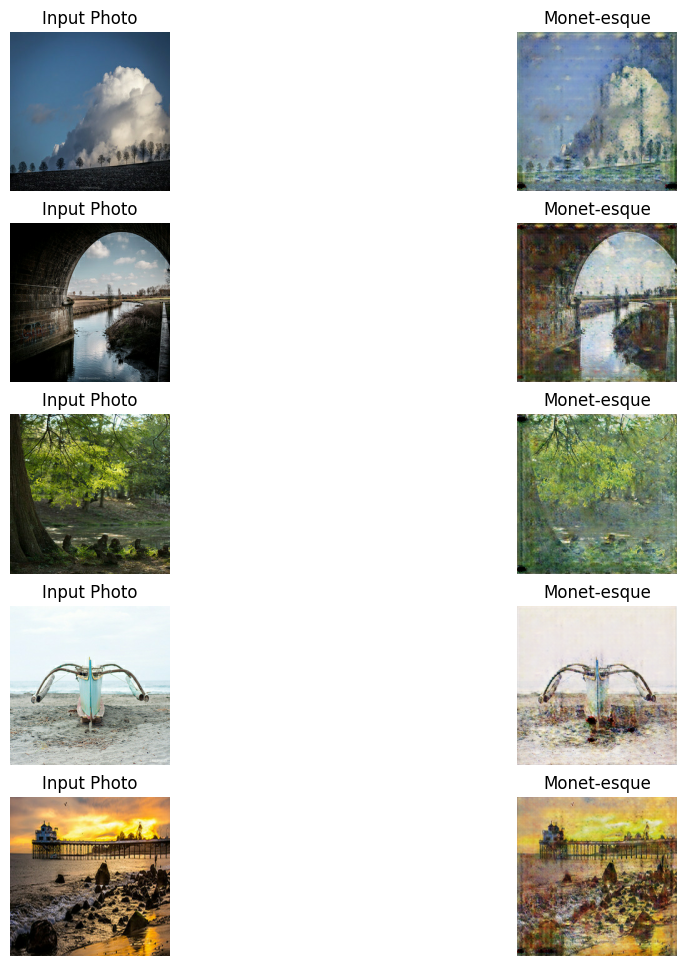

In [26]:
visualize_predictions(photo_dataset, monet_generator)

In [28]:
save_predictions(photo_dataset, monet_generator)

Predictions saved to C:\Users\Ryan\Files\DTSA 5511\Week 5\results_2


## Conclusion

In this project we have learning about General Adversarial Networks and their applications in image training by utilizing CycleGANs. We learned how to implement a simple model with a generator and discriminator and then tried to improve it by creating a two-objective model which utilized 2 discriminators using both hinge loss and binary crossentropy loss. This resulted in a model that trained and evaluated better. We implemented data augmentation to improve the generalization of training and created a model that could translate photo images into monet style images.